In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
df = pd.read_csv('aa.csv', sep=',', encoding = 'euc-kr')
df = df.drop('Silver($)',axis = 1)
df

,date,Gold,Silver,Dow,Nas,S&P,CNY,EUR,JPY,USD
0,20100802,44534.63,694.507049,10674.38,2295.36,1125.86,173.36,1534.18,1352.69,1174.0
1,20100803,44425.74,691.629077,10636.38,2283.52,1120.46,172.49,1545.93,1359.20,1168.5
2,20100804,45009.08,686.874468,10680.43,2303.57,1127.24,172.74,1543.23,1368.42,1170.0
3,20100805,44870.25,685.811886,10674.98,2293.06,1125.81,172.02,1531.28,1349.94,1165.0
4,20100806,44660.81,690.243220,10653.56,2288.47,1121.64,171.75,1534.00,1350.28,1163.0
...,...,...,...,...,...,...,...,...,...,...
2597,20200727,74332.14,942.098478,26584.77,10536.27,3239.41,170.88,1403.60,1136.81,1197.0
2598,20200728,74342.85,935.967496,26379.28,10402.09,3218.44,171.27,1407.61,1140.26,1199.5
2599,20200729,75110.45,932.827495,26539.57,10542.94,3258.44,170.56,1401.40,1137.09,1194.0
2600,20200730,75110.59,897.475847,26313.65,10587.81,3246.22,170.68,1404.82,1138.13,1196.0


In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)- target_size
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        
        data.append(np.reshape(dataset[indices], (history_size,1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)    

In [4]:
TRAIN_SPLIT = 1200
tf.random.set_seed(2020)

In [5]:
uni_data = df['Nas']
uni_data.index = df['date']
uni_data

date
20100802     2295.36
20100803     2283.52
20100804     2303.57
20100805     2293.06
20100806     2288.47
              ...   
20200727    10536.27
20200728    10402.09
20200729    10542.94
20200730    10587.81
20200731    10745.28
Name: Nas, Length: 2602, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EA6047CF88>],
      dtype=object)

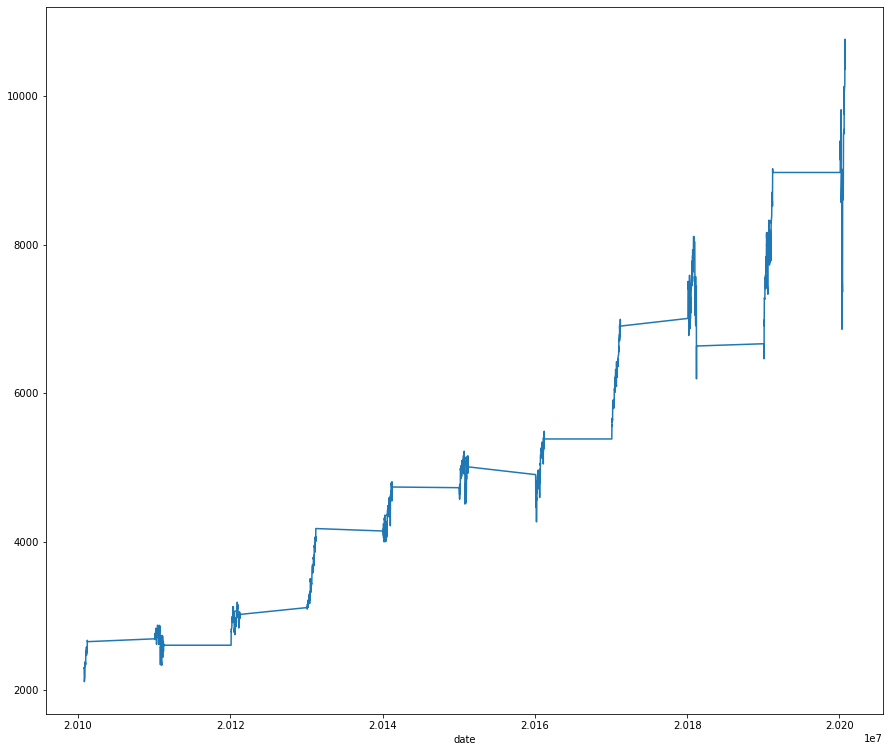

In [6]:
plt.figure(figsize=(15,13))
uni_data.plot(subplots = True)

In [7]:
uni_data = uni_data.values

In [8]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean)/uni_train_std

In [9]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                          univariate_past_history,
                                          univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                          univariate_past_history,
                                          univariate_future_target)

In [10]:
print("Single window of past history")
print(x_train_uni[0])
print("\n Target Nas to predict")
print(y_train_uni[0])

Single window of past history
[[-1.40654471]
 [-1.42218171]
 [-1.39570182]
 [-1.4095823 ]
 [-1.41564428]
 [-1.39290195]
 [-1.43056811]
 [-1.52108838]
 [-1.5453363 ]
 [-1.56751073]
 [-1.55643011]
 [-1.52001862]
 [-1.51175108]
 [-1.56028654]
 [-1.55921678]
 [-1.58580232]
 [-1.63317556]
 [-1.60969365]
 [-1.63987148]
 [-1.59372647]]

 Target Nas to predict
-1.6381809885408263


In [11]:
def create_time_steps(length):
    return list(range(-length, 0))

In [12]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future","Model Predition"]
    marker = ['.-','rx','go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i],
                     markersize = 10,label = labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(),
                     marker[i], label = labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    plt.show()
        
    return plt

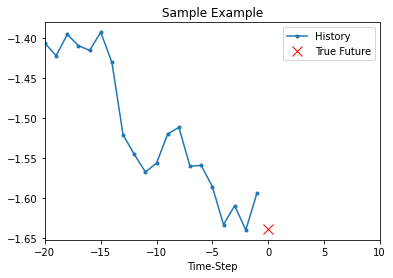

<module 'matplotlib.pyplot' from 'C:\\Users\\pc\\.conda\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [13]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, "Sample Example")

In [14]:
def baseline(history):
    return np.mean(history)

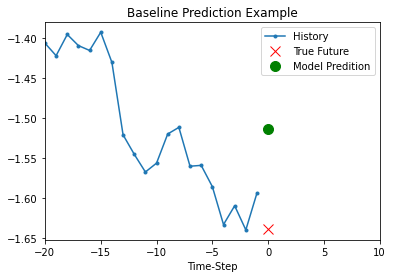

<module 'matplotlib.pyplot' from 'C:\\Users\\pc\\.conda\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [15]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, "Baseline Prediction Example")

In [16]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni,y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni,y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [17]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape = x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer = "adam", loss= "mae")

In [18]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [19]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs = EPOCHS,
                     steps_per_epoch = EVALUATION_INTERVAL,
                     validation_data = val_univariate, validation_steps = 50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2849 - val_loss: 3.0401
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0723 - val_loss: 2.6359
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0522 - val_loss: 2.4746
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0469 - val_loss: 2.3815
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0435 - val_loss: 2.3130
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0411 - val_loss: 2.2608
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0391 - val_loss: 2.2131
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0375 - val_loss: 2.1735
Epoch 9/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0363 - val_loss: 2.1368
Epoch 10/10
200/200 [==============================] - 1

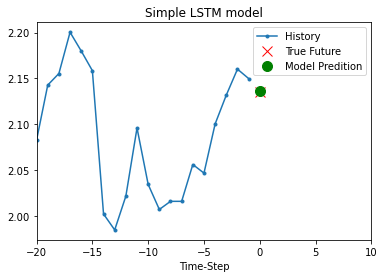

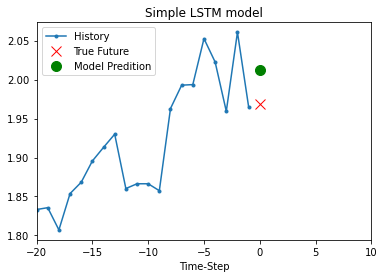

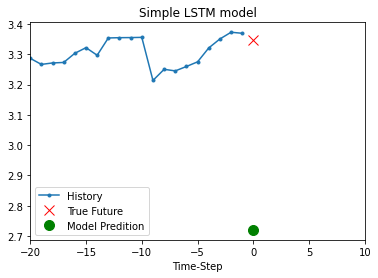

In [20]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                     simple_lstm_model.predict(x)[0]],0, "Simple LSTM model")
    plt.show()

# Multivariate 시계열 예측

In [21]:
features_considered = ['Gold','Silver','Dow','Nas','S&P','CNY','EUR','JPY','USD']

In [22]:
features = df[features_considered]
features.index = df['date']
features

,Gold,Silver,Dow,Nas,S&P,CNY,EUR,JPY,USD
date,,,,,,,,,
20100802,44534.63,694.507049,10674.38,2295.36,1125.86,173.36,1534.18,1352.69,1174.0
20100803,44425.74,691.629077,10636.38,2283.52,1120.46,172.49,1545.93,1359.20,1168.5
20100804,45009.08,686.874468,10680.43,2303.57,1127.24,172.74,1543.23,1368.42,1170.0
20100805,44870.25,685.811886,10674.98,2293.06,1125.81,172.02,1531.28,1349.94,1165.0
20100806,44660.81,690.243220,10653.56,2288.47,1121.64,171.75,1534.00,1350.28,1163.0
...,...,...,...,...,...,...,...,...,...
20200727,74332.14,942.098478,26584.77,10536.27,3239.41,170.88,1403.60,1136.81,1197.0
20200728,74342.85,935.967496,26379.28,10402.09,3218.44,171.27,1407.61,1140.26,1199.5
20200729,75110.45,932.827495,26539.57,10542.94,3258.44,170.56,1401.40,1137.09,1194.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EA607BD088>,
      dtype=object)

<Figure size 1080x648 with 0 Axes>

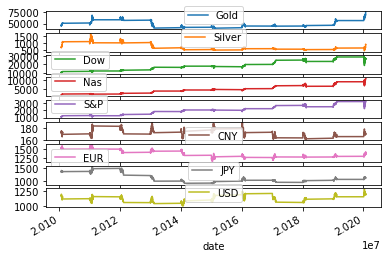

In [23]:
plt.figure(figsize=(15, 9))
features.plot(subplots= True)

In [24]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis = 0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset - data_mean)/data_std

In [25]:
features

,Gold,Silver,Dow,Nas,S&P,CNY,EUR,JPY,USD
date,,,,,,,,,
20100802,44534.63,694.507049,10674.38,2295.36,1125.86,173.36,1534.18,1352.69,1174.0
20100803,44425.74,691.629077,10636.38,2283.52,1120.46,172.49,1545.93,1359.20,1168.5
20100804,45009.08,686.874468,10680.43,2303.57,1127.24,172.74,1543.23,1368.42,1170.0
20100805,44870.25,685.811886,10674.98,2293.06,1125.81,172.02,1531.28,1349.94,1165.0
20100806,44660.81,690.243220,10653.56,2288.47,1121.64,171.75,1534.00,1350.28,1163.0
...,...,...,...,...,...,...,...,...,...
20200727,74332.14,942.098478,26584.77,10536.27,3239.41,170.88,1403.60,1136.81,1197.0
20200728,74342.85,935.967496,26379.28,10402.09,3218.44,171.27,1407.61,1140.26,1199.5
20200729,75110.45,932.827495,26539.57,10542.94,3258.44,170.56,1401.40,1137.09,1194.0


In [26]:
features.values[:,2]

array([10674.38, 10636.38, 10680.43, ..., 26539.57, 26313.65, 26428.32])

In [27]:
def multivariate_data(dataset, target, start_index, end_index,
                     history_size, target_size, step, single_step = False):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)-target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i , step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
            
    return np.array(data), np.array(labels)

In [28]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset,dataset[:,3], 0 ,
                                                  TRAIN_SPLIT, past_history,
                                                  future_target, STEP,
                                                  single_step=True)
x_val_single, y_val_single = multivariate_data(dataset,dataset[:,3],
                                                  TRAIN_SPLIT, None, past_history,
                                                  future_target, STEP,
                                                  single_step=True)

In [29]:
print("Single window of past histroy : {}".format(x_train_single[0].shape))

Single window of past histroy : (120, 9)


In [30]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single,y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single,y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [31]:
single_step_model = Sequential()
single_step_model.add(LSTM(32, input_shape = x_train_single.shape[-2:]))
single_step_model.add(Dense(1))
single_step_model.compile(optimizer = RMSprop(), loss='mae')

In [32]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [33]:
single_step_history = single_step_model.fit(train_data_single, epochs = EPOCHS,
                                           steps_per_epoch = EVALUATION_INTERVAL,
                                           validation_data = val_data_single,
                                           validation_steps = 50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 14s 69ms/step - loss: 0.1247 - val_loss: 4.6577
Epoch 2/10
200/200 [==============================] - 11s 57ms/step - loss: 0.0744 - val_loss: 4.3229
Epoch 3/10
200/200 [==============================] - 12s 58ms/step - loss: 0.0614 - val_loss: 4.4111
Epoch 4/10
200/200 [==============================] - 12s 58ms/step - loss: 0.0556 - val_loss: 4.2525
Epoch 5/10
200/200 [==============================] - 12s 58ms/step - loss: 0.0529 - val_loss: 4.1988
Epoch 6/10
200/200 [==============================] - 12s 59ms/step - loss: 0.0504 - val_loss: 4.1684
Epoch 7/10
200/200 [==============================] - 12s 59ms/step - loss: 0.0485 - val_loss: 4.1515
Epoch 8/10
200/200 [==============================] - 12s 58ms/step - loss: 0.0467 - val_loss: 4.1459
Epoch 9/10
200/200 [==============================] - 12s 59ms/step - loss: 0.0452 - val_loss: 4.2350
Epoch 10/10
200/200 [==================

In [34]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

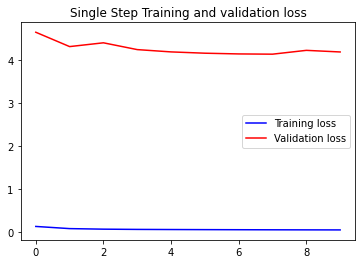

In [35]:
plot_train_history(single_step_history,
                  "Single Step Training and validation loss")

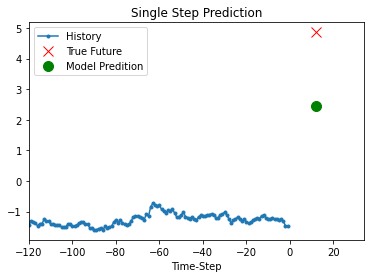

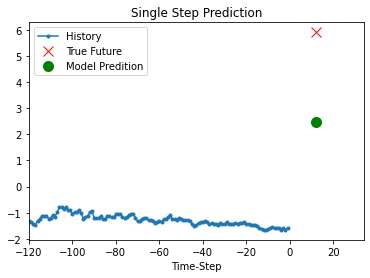

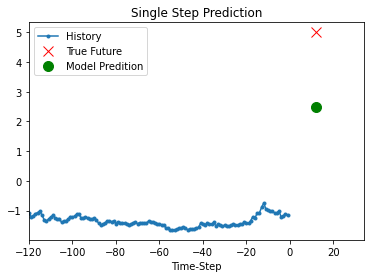

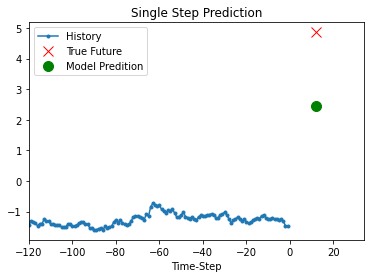

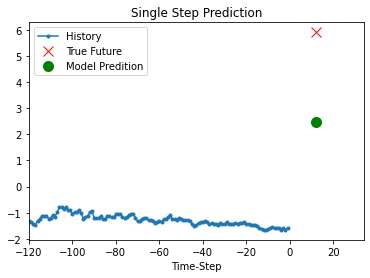

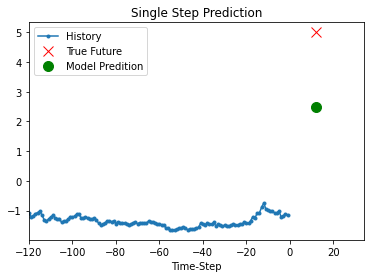

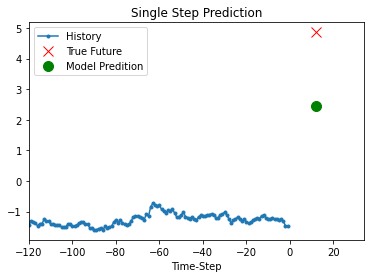

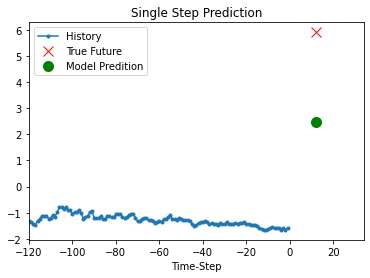

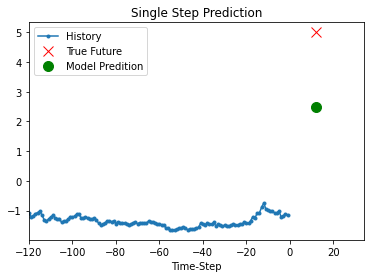

In [36]:
for x , y in val_data_single.take(9):
    plot = show_plot([x[0][:,1].numpy(), y[0].numpy(),
                     single_step_model.predict(x)[0]],12,
                    'Single Step Prediction')
    plot.show()

In [37]:
future_target = 72

x_train_multi, y_train_multi = multivariate_data(dataset,dataset[:,3], 0 ,
                                                  TRAIN_SPLIT, past_history,
                                                  future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset,dataset[:,3],
                                                  TRAIN_SPLIT, None, past_history,
                                                  future_target, STEP)

In [38]:
dataset

array([[-0.93122123, -0.94404395, -1.53698692, ...,  0.98934995,
         0.64226372,  1.79134281],
       [-0.94567386, -0.95508562, -1.55438204, ...,  1.14116841,
         0.67668016,  1.6575637 ],
       [-0.86824894, -0.97332724, -1.53421743, ...,  1.10628247,
         0.72542356,  1.69404891],
       ...,
       [ 3.12701323, -0.02969954,  5.7255656 , ..., -0.72626321,
        -0.49754947,  2.2778123 ],
       [ 3.12703181, -0.1653303 ,  5.62214699, ..., -0.68207435,
        -0.4920513 ,  2.32645925],
       [ 3.1958255 , -0.05485185,  5.67463908, ..., -0.60558369,
        -0.49633353,  2.20484188]])

In [39]:
print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('\nTarget Price to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 9)

Target Price to predict : (72,)


In [40]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi,y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi,y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [41]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize = (12,6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.plot(num_in, np.array(history[:,1]), label= "HISTORY")
    plt.plot(np.arange(num_out)/STEP, np.array(true_future),'bo',
            label = 'True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),'ro',
                label = 'Prediction Future')
        
    plt.legend(loc='upper left')
    plt.show()

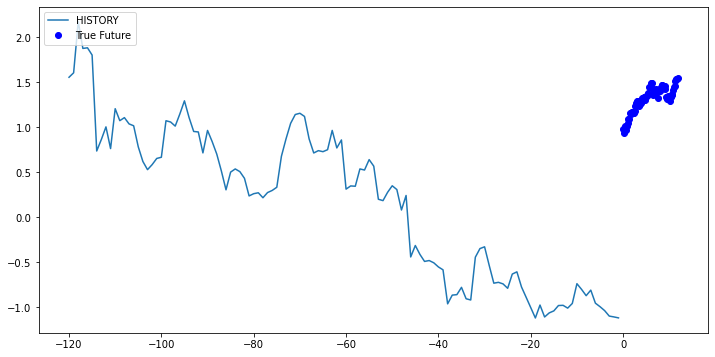

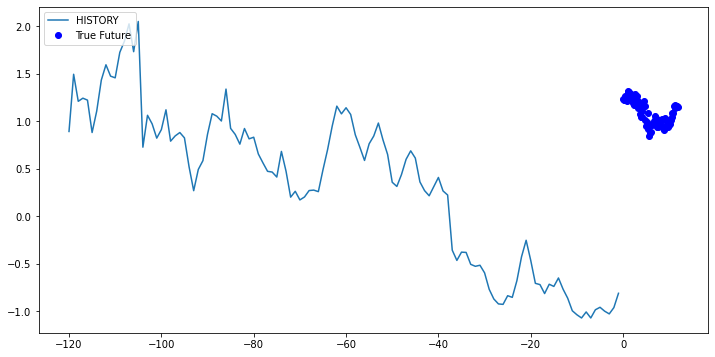

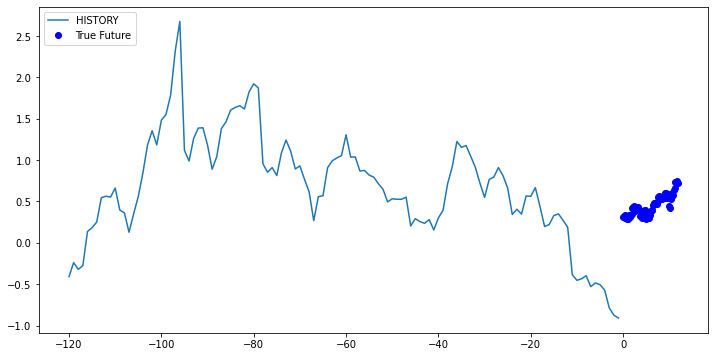

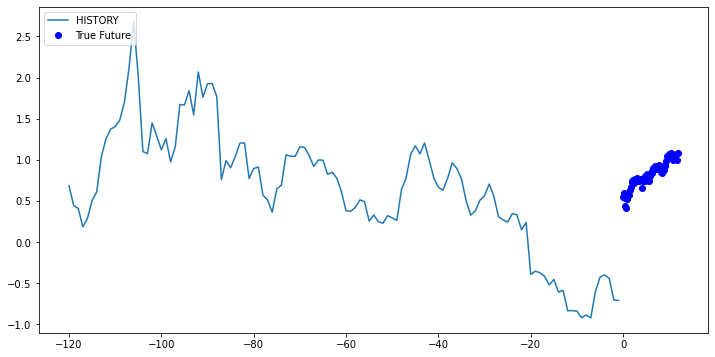

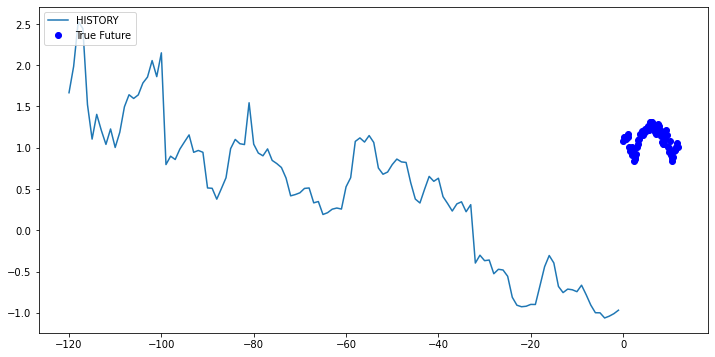

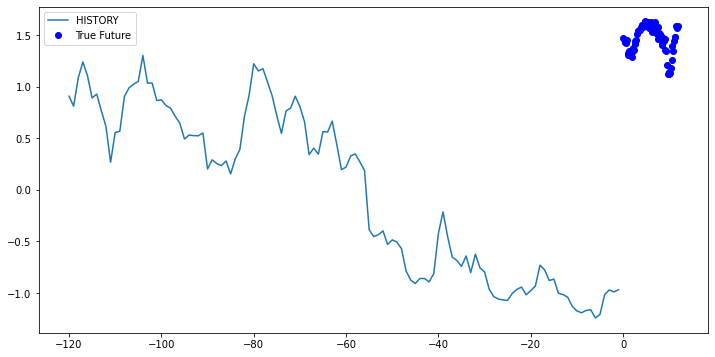

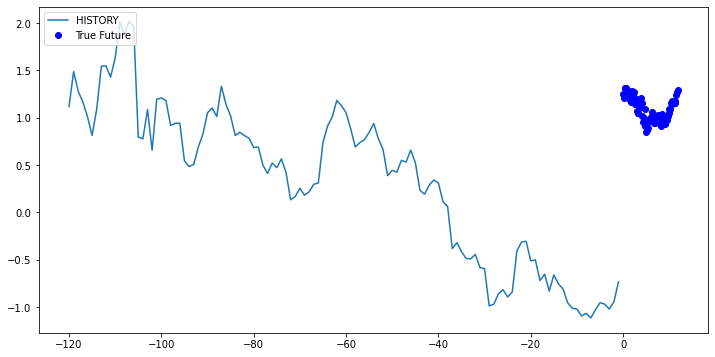

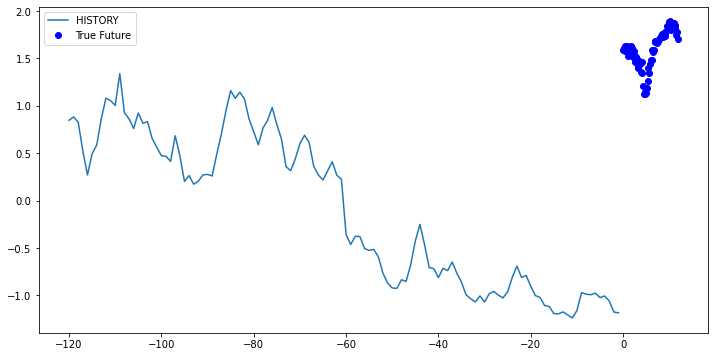

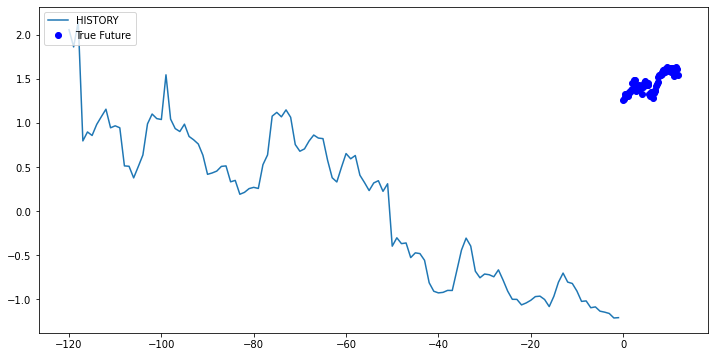

In [42]:
for x, y in train_data_multi.take(9):
    multi_step_plot(x[0],y[0],np.array([0]))

In [43]:
multi_step_model = Sequential()
multi_step_model.add(LSTM(32, return_sequences=True,
                         input_shape = x_train_multi.shape[-2:]))
multi_step_model.add(LSTM(16,activation = 'relu'))
multi_step_model.add(Dense(72))

multi_step_model.compile(optimizer = RMSprop(clipvalue = 1.0), loss = 'mae')

In [44]:
for x , y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

(256, 72)


In [45]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs = EPOCHS,
                                         steps_per_epoch = EVALUATION_INTERVAL,
                                         validation_data = val_data_multi,
                                         validation_steps = 50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 23s 116ms/step - loss: 0.3982 - val_loss: 3.9625
Epoch 2/10
200/200 [==============================] - 22s 108ms/step - loss: 0.1119 - val_loss: 3.9981
Epoch 3/10
200/200 [==============================] - 21s 103ms/step - loss: 0.1008 - val_loss: 3.9788
Epoch 4/10
200/200 [==============================] - 21s 104ms/step - loss: 0.0962 - val_loss: 4.0256
Epoch 5/10
200/200 [==============================] - 20s 102ms/step - loss: 0.0931 - val_loss: 4.1453
Epoch 6/10
200/200 [==============================] - 21s 104ms/step - loss: 0.0892 - val_loss: 3.9802
Epoch 7/10
200/200 [==============================] - 21s 104ms/step - loss: 0.0850 - val_loss: 3.9639
Epoch 8/10
200/200 [==============================] - 21s 103ms/step - loss: 0.0814 - val_loss: 4.0371
Epoch 9/10
200/200 [==============================] - 21s 104ms/step - loss: 0.0775 - val_loss: 4.0174
Epoch 10/10
200/200 [=========

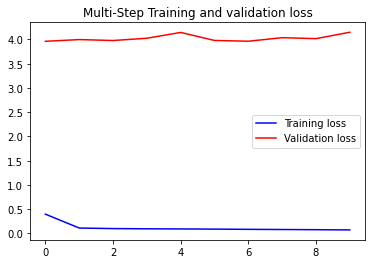

In [46]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

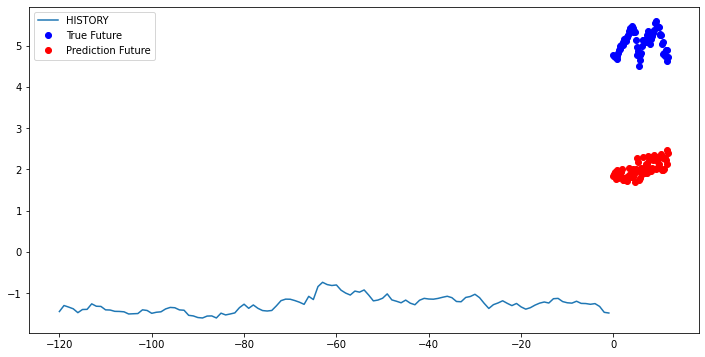

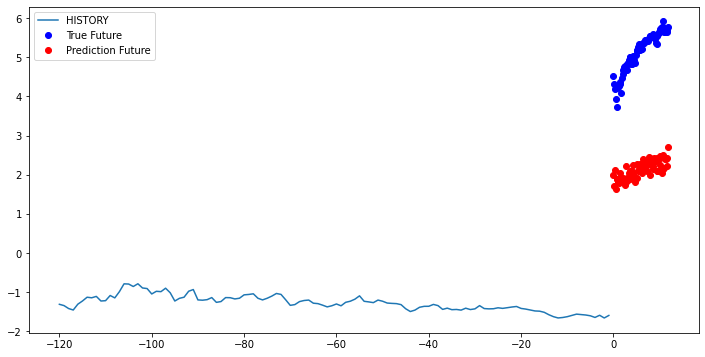

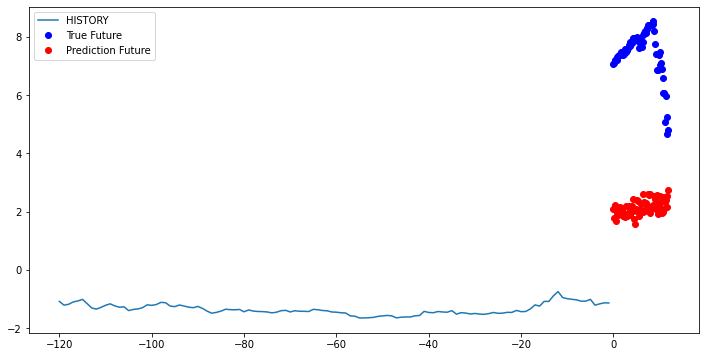

In [47]:
for x , y in val_data_multi.take(3):
    multi_step_plot(x[0],y[0],multi_step_model.predict(x)[0])